In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import glob
import os
import cv2
import time

from PIL import Image

from scipy.spatial import cKDTree
from scipy.ndimage import binary_fill_holes

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: cuda


In [3]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/wsl/bin/segment-anything/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

/home/wsl/bin/anaconda3/envs/sam-2/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [53]:
def remove_points_near_border(points, contour, border_dist_threshold):
    filtered_points = []

    # Iterate over all points
    for point in points:
        # Check the distance of the point to the contour
        dist_to_contour = cv2.pointPolygonTest(contour, (point[0], point[1]), True)
        
        # Keep the point if it's farther from the border than the threshold
        if dist_to_contour >= border_dist_threshold:
            filtered_points.append(point)
    
    return filtered_points


def remove_background_1(wing_image):
    # Image dimensions
    height, width, _ = wing_image.shape
    
    # Calculate points
    point_1 = (width // 3, height // 2)
    point_2 = (2 * width // 3, height // 2)
    points = [point_1, point_2]
    
    # Convert the points list to a numpy array
    image_points = np.array(points)
    image_labels = np.array([1] * len(points))

    # Plot the contour and the selected points
    plt.figure(figsize=(5, 5))
    plt.imshow(wing_image)
    plt.scatter(image_points[:, 0], image_points[:, 1], c="red", s=5)
    plt.axis('off')
    plt.show()
    
    predictor.set_image(wing_image)
    
    mask, score, _ = predictor.predict(
        point_coords=image_points,
        point_labels=image_labels,
        multimask_output=False,
    )
    sorted_ind = np.argsort(score)[::-1]
    mask = mask[sorted_ind]
    score = score[sorted_ind]
    
    # Remove extra dimension
    mask = mask.squeeze()

    # Fill holes in the mask
    filled_mask = binary_fill_holes(mask).astype(int)
    
    # Create a white image of the same size as the original image
    white_image = np.ones_like(wing_image) * 255
    
    # Apply the mask to each channel (no extra dimension added)
    wing_image = np.where(filled_mask[:, :, None], wing_image, white_image)
    
    return wing_image
    
    
def remove_background_2(wing_image):  
    # Convert the image to grayscale
    gray = cv2.cvtColor(wing_image, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to get a binary image
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    
    # Invert the binary image
    inv_thresh = cv2.bitwise_not(thresh)
    return inv_thresh


def remove_background_3(wing_image):
    # Grayscale image
    gray = cv2.cvtColor(wing_image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)
    
    contour_images = []
    wing_contours = []
    
    threshold = 250
    while threshold >= 0:
        # Apply thresholding to get a binary image
        _, thresh = cv2.threshold(blurred_image, threshold, 255, cv2.THRESH_BINARY)
    
        # Invert the binary image
        inv_thresh = cv2.bitwise_not(thresh)
        
        # Fill holes in the mask
        inv_thresh = binary_fill_holes(inv_thresh).astype(np.uint8) 

        # Scale to match the binary image format
        inv_thresh = inv_thresh * 255

        # Find contour
        all_contours, _ = cv2.findContours(inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours on the image for visualization
        wing_contour_image_1 = wing_image.copy()
        cv2.drawContours(wing_contour_image_1, all_contours, -1, (255, 0, 0), 20)

        # Ensure there are contours before proceeding
        wing_contour_image_2 = wing_image.copy()
        if all_contours:
            # Find the largest contour by area
            largest_contour = max(all_contours, key=cv2.contourArea)
        
            # Optional: Get the area of the largest contour (for verification or further use)
            largest_area = cv2.contourArea(largest_contour)
    
            # Calculate the total image area
            image_area = inv_thresh.shape[0] * inv_thresh.shape[1]
        
            # Calculate the percentage
            percentage_area = (largest_area / image_area) * 100

            # print(f"Contour area: {percentage_area}")
            if (50 > percentage_area > 20):
                cv2.drawContours(wing_contour_image_2, largest_contour, -1, (0, 0, 255), 10)
                contour_images.append(wing_contour_image_2)
                wing_contours.append(largest_contour)
            else:
                cv2.drawContours(wing_contour_image_2, largest_contour, -1, (255, 0, 0), 10)
        """
        # Show identification process
        print(f"threshold: {threshold}\tcontours: {len(all_contours)}")
        # Create a 1x3 figure
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))
        # Image 1
        axes[0].imshow(inv_thresh, cmap="gray")
        axes[0].axis("off")
        axes[0].set_title(f"inverted threshold", size=25)
        # Image 2
        axes[1].imshow(wing_contour_image_1)
        axes[1].axis("off") 
        axes[1].set_title(f"All Contours ({len(all_contours)}]", size=25)
        # Image 3
        axes[2].imshow(wing_contour_image_2)
        axes[2].axis("off") 
        axes[2].set_title(f"Largest Contour", size=25)
        
        # Show the figure
        plt.tight_layout()
        plt.show()
        """
        threshold -= 10

    if len(contour_images) == 0:
        print("No Contours Identified!")
        return None
        
    wing = contour_images[len(contour_images) // 2]
    contour = wing_contours[len(wing_contours) // 2]

    # Get bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Create a dense grid of points within the bounding box
    distance = 200  
    height, width, channels = wing_image.shape  
    
    # Create x and y coordinates
    x_coords = np.arange(0, width, distance)
    y_coords = np.arange(0, height, distance)
    
    # Create a meshgrid from the x and y coordinates
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)
    
    # Stack the x and y coordinates into a single array of points
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
    
    # Convert the NumPy array to a list of tuples with standard integers
    grid_points = [(int(x), int(y)) for x, y in grid_points]
    
    inside_points = []
    
    # Check if points are inside the contour
    for point in grid_points:
        if cv2.pointPolygonTest(contour, (point[0], point[1]), False) >= 0:
            inside_points.append(point)

    filtered_points = np.array(remove_points_near_border(inside_points, contour, 25))
    
    # Plot the contour and the selected points
    plt.figure(figsize=(5, 5))
    plt.imshow(wing)
    plt.scatter(filtered_points[:, 0], filtered_points[:, 1], c="blue", s=5)
    plt.axis('off')
    plt.show()

    # Convert the points list to a numpy array
    image_points = np.array(filtered_points)
    image_labels = np.array([1] * len(filtered_points))

    predictor.set_image(wing_image)
    
    mask, score, _ = predictor.predict(
        point_coords=image_points,
        point_labels=image_labels,
        multimask_output=False,
    )
    sorted_ind = np.argsort(score)[::-1]
    mask = mask[sorted_ind]
    score = score[sorted_ind]
    
    # Remove extra dimension
    mask = mask.squeeze()

    # Fill holes in the mask
    filled_mask = binary_fill_holes(mask).astype(int)
    
    # Create a white image of the same size as the original image
    white_image = np.ones_like(wing_image) * 255
    
    # Apply the mask to each channel (no extra dimension added)
    wing_image = np.where(filled_mask[:, :, None], wing_image, white_image)
    
    return wing_image

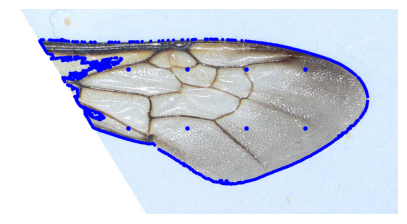

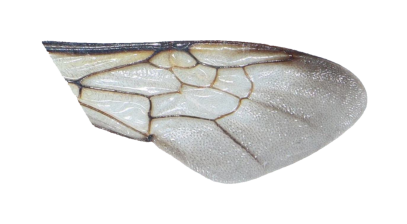

In [54]:
test_1 = "/mnt/c/Projects/Master/Data/Processed/2-LiveWingWingCropsImproved/Round01-Hive01-2024_06_05-h01bee01.JPG"
test_2 = "/mnt/c/Projects/Master/Data/Processed/2-LiveWingWingCropsImproved/Round01-Hive01-2024_06_11-h01b05.JPG"


image = cv2.imread(test_2)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

wing_image = remove_background_3(image)

if wing_image is not None:
    plt.figure(figsize=(5, 5))
    plt.imshow(wing_image)
    plt.axis("off")
    plt.show()

Processing file 0001/1147:	Round01-Hive01-2024_06_05-h01bee01.JPG


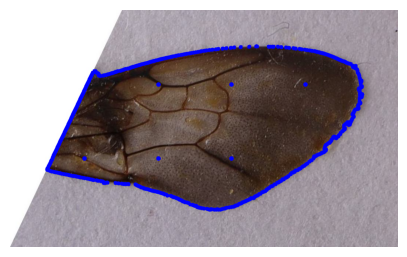

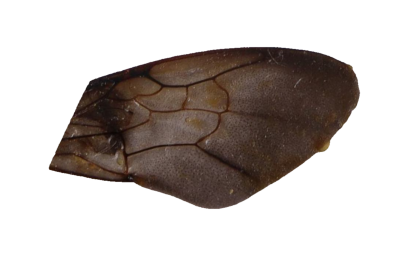

Processing file 0002/1147:	Round01-Hive01-2024_06_05-h01bee16.JPG


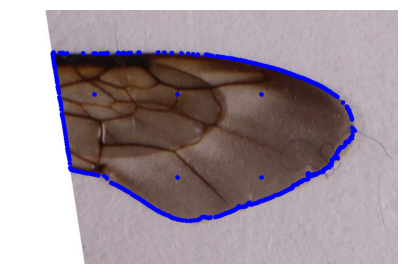

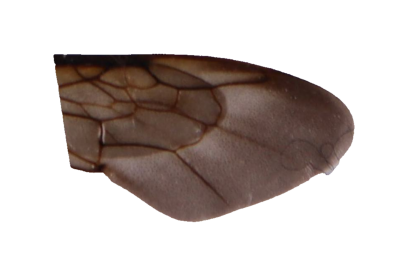

Processing file 0003/1147:	Round01-Hive01-2024_06_05-h01bee19.JPG


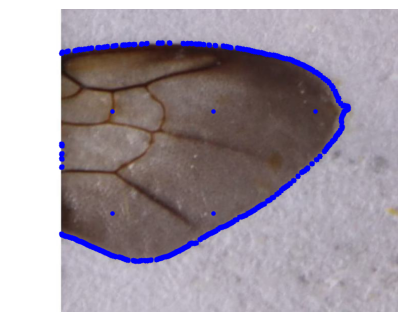

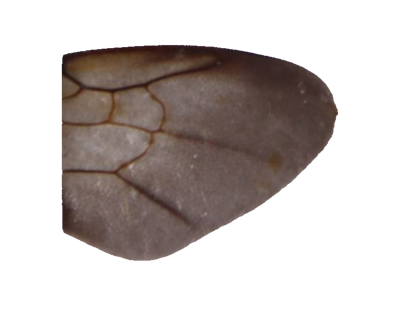

Processing file 0004/1147:	Round01-Hive01-2024_06_05-h01bee29.JPG


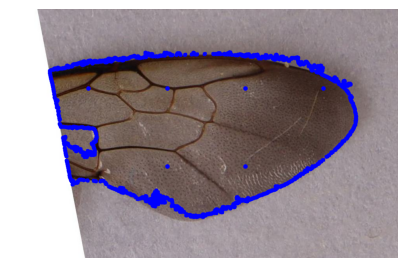

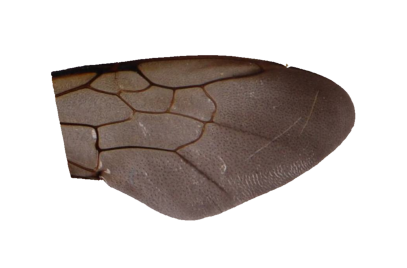

Processing file 0005/1147:	Round01-Hive01-2024_06_05-h01bee32.JPG


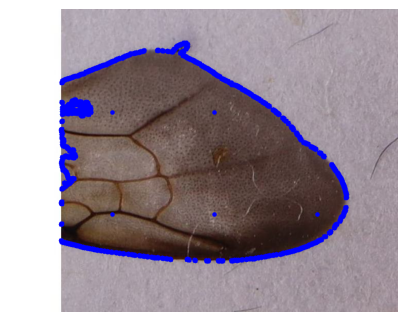

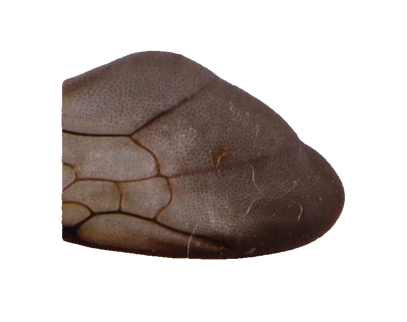

Processing file 0006/1147:	Round01-Hive01-2024_06_05-h01bee37.JPG


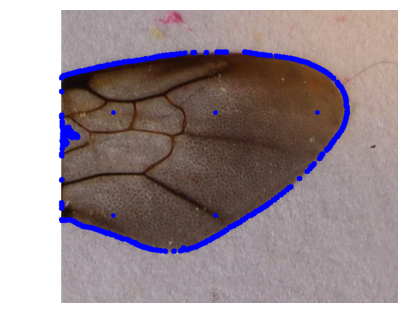

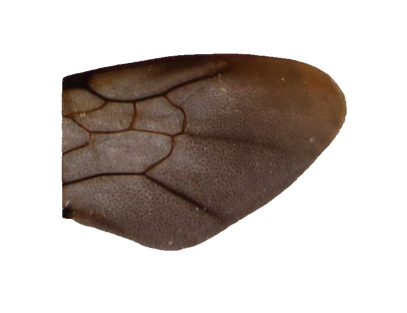

Processing file 0007/1147:	Round01-Hive01-2024_06_05-h01bee46.JPG


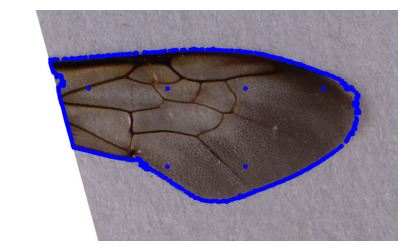

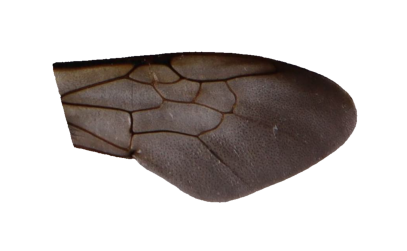

Processing file 0008/1147:	Round01-Hive01-2024_06_05-h01bee51.JPG


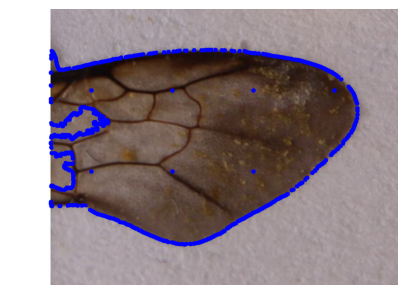

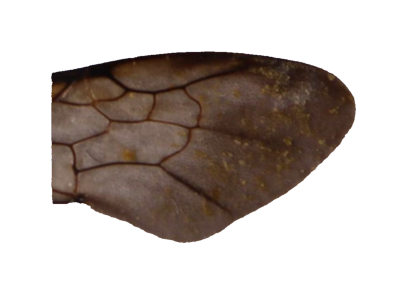

Processing file 0009/1147:	Round01-Hive01-2024_06_11-h01b02.JPG


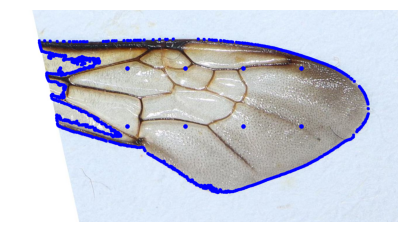

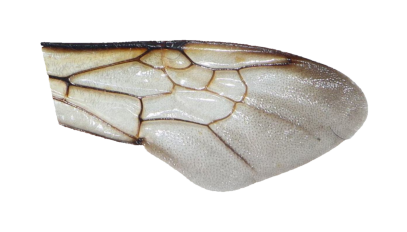

Processing file 0010/1147:	Round01-Hive01-2024_06_11-h01b05.JPG


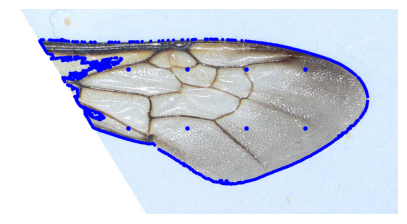

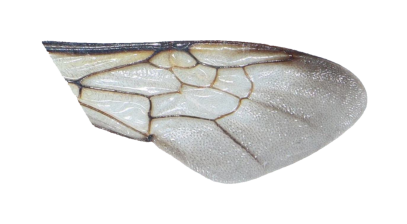

Processing file 0011/1147:	Round01-Hive01-2024_06_11-h01b18.JPG


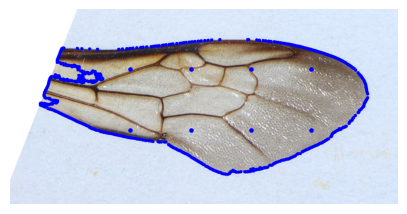

KeyboardInterrupt: 

In [56]:
input_dir = "/mnt/c/Projects/Master/Data/Processed/2-LiveWingWingCropsImproved/"

# Find all jpg files
jpg_files = []
for root, _, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".JPG") or file.endswith(".jpg"):
            jpg_files.append(os.path.join(root, file))

# Process every file
total_files = len(jpg_files)
digits = len(str(total_files))
for idx, jpg_file_path in enumerate(jpg_files, 1):
    jpg_basename = os.path.basename(jpg_file_path)
    relative_jpg_path = jpg_file_path.removeprefix(input_dir)
    print(f"Processing file {idx:0{digits}}/{total_files}:\t{relative_jpg_path}")
    
    # Process image
    image = cv2.imread(jpg_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)
    
    """
    wing_image = remove_background_1(image)
    
    # Plot the contour and the selected points
    plt.figure(figsize=(5, 5))
    plt.imshow(wing_image)
    plt.axis("off")
    plt.show()
    """
    """
    wing_image = remove_background_2(image)
    
    # Plot the contour and the selected points
    plt.figure(figsize=(5, 5))
    plt.imshow(wing_image, cmap="gray")
    plt.axis("off")
    plt.show()
    """
    
    wing_image = remove_background_3(image)

    if wing_image is not None:
        plt.figure(figsize=(5, 5))
        plt.imshow(wing_image)
        plt.axis("off")
        plt.show()